**Mask-RCNN Model with transfer learning **

Using pre-trained COCO weights trained on http://cocodataset.org as in https://github.com/matterport/Mask_RCNN

In [1]:
import os 
import sys
import random
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
import pydicom
from imgaug import augmenters as iaa
from tqdm import tqdm
import pandas as pd 
import glob 

In [2]:
DATA_DIR = '/kaggle/input'

# Directory to save miscellanious files during training, logs and model data
ROOT_DIR = '/kaggle/working'

### Install Matterport's Mask-RCNN model.
See the implementation details [here](https://github.com/matterport/Mask_RCNN).

In [3]:
!git clone https://www.github.com/matterport/Mask_RCNN.git
os.chdir('Mask_RCNN')

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 119.70 MiB | 42.05 MiB/s, done.
Resolving deltas: 100% (555/555), done.


In [4]:
# Import Mask RCNN from cloned git repo
sys.path.append(os.path.join(ROOT_DIR, 'Mask_RCNN'))  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

Using TensorFlow backend.


In [5]:
train_dicom_dir = os.path.join(DATA_DIR, 'stage_2_train_images')
test_dicom_dir = os.path.join(DATA_DIR, 'stage_2_test_images')

Let's make sure we do the least work we have to by using the pretrained weights from the COCO dataset. This will ensure that our model has learned the basic features of images such as lines, shapes, and color changes. We'll do this by downloading the HDF5 container file (.h5) for the weights of the Mask RCNN model.
more on HDF5 [here](http://docs.h5py.org/en/stable/quick.html) 

In [6]:
### Download COCO pre-trained weights
!wget --quiet https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5
!ls -lh mask_rcnn_coco.h5

COCO_WEIGHTS_PATH = "mask_rcnn_coco.h5"

-rw-r--r-- 1 root root 246M Nov 26  2017 mask_rcnn_coco.h5


### Some setup functions and classes for Mask-RCNN

- dicom_fps is a list of the dicom image path and filenames 
- image_annotions is a dictionary of the annotations keyed by the filenames
- parsing the dataset returns a list of the image filenames and the annotations dictionary

In [7]:
def get_dicom_fps(dicom_dir):
    dicom_fps = glob.glob(dicom_dir+'/'+'*.dcm')
    return list(set(dicom_fps))

def parse_dataset(dicom_dir, anns): 
    image_fps = get_dicom_fps(dicom_dir)
    image_annotations = {fp: [] for fp in image_fps}
    for index, row in anns.iterrows(): 
        fp = os.path.join(dicom_dir, row['patientId']+'.dcm')
        image_annotations[fp].append(row)
    return image_fps, image_annotations 

In [8]:
# These are not optimal 

class DetectorConfig(Config):
    """Configuration for training pneumonia detection on the RSNA pneumonia dataset.
    Overrides values in the base Config class.
    """
    
    # Give the configuration a recognizable name  
    NAME = 'pneumonia'
    
    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are relatively small. Batch size is 8 (GPUs * images/GPU).
    # feel free to increase this if you have more GPUs in your system. 
    # It will boost performance significantly.
    GPU_COUNT = 1 
    IMAGES_PER_GPU = 8
    
    BACKBONE = 'resnet50'
    
    NUM_CLASSES = 2  # background + 1 pneumonia class
    
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256
    RPN_ANCHOR_SCALES = (32, 64, 128, 256)
    TRAIN_ROIS_PER_IMAGE = 32
    MAX_GT_INSTANCES = 3
    DETECTION_MAX_INSTANCES = 3
    DETECTION_MIN_CONFIDENCE = 0.7
    DETECTION_NMS_THRESHOLD = 0.1

    STEPS_PER_EPOCH = 200
    
config = DetectorConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        3
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.1
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                

In [9]:
class DetectorDataset(utils.Dataset):
    """Dataset class for preparing data for pneumonia detection. Inherits from matterport's Mask RCNN utils.Dataset
    """

    def __init__(self, image_fps, image_annotations, orig_height, orig_width):
        super().__init__(self)
        
        # Add classes we weill use for this challenge
        self.add_class('pneumonia', 1, 'Lung Opacity')
        
        # add images 
        for i, fp in enumerate(image_fps):
            annotations = image_annotations[fp]
            self.add_image('pneumonia', image_id=i, path=fp, 
                           annotations=annotations, orig_height=orig_height, orig_width=orig_width)
            
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

    def load_image(self, image_id):
        info = self.image_info[image_id]
        fp = info['path']
        ds = pydicom.read_file(fp)
        image = ds.pixel_array
        # If grayscale. Convert to RGB for consistency.
        if len(image.shape) != 3 or image.shape[2] != 3:
            image = np.stack((image,) * 3, -1)
        return image

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        annotations = info['annotations']
        count = len(annotations)
        if count == 0:
            mask = np.zeros((info['orig_height'], info['orig_width'], 1), dtype=np.uint8)
            class_ids = np.zeros((1,), dtype=np.int32)
        else:
            mask = np.zeros((info['orig_height'], info['orig_width'], count), dtype=np.uint8)
            class_ids = np.zeros((count,), dtype=np.int32)
            for i, a in enumerate(annotations):
                if a['Target'] == 1:
                    x = int(a['x'])
                    y = int(a['y'])
                    w = int(a['width'])
                    h = int(a['height'])
                    mask_instance = mask[:, :, i].copy()
                    cv2.rectangle(mask_instance, (x, y), (x+w, y+h), 255, -1)
                    mask[:, :, i] = mask_instance
                    class_ids[i] = 1
        return mask.astype(np.bool), class_ids.astype(np.int32)

### Examine the annotation data, parse the dataset, and view dicom fields

In [10]:
# training dataset
anns = pd.read_csv(os.path.join(DATA_DIR, 'stage_2_train_labels.csv'))
anns.head(10)

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1
6,00569f44-917d-4c86-a842-81832af98c30,NaN,NaN,NaN,NaN,0
7,006cec2e-6ce2-4549-bffa-eadfcd1e9970,NaN,NaN,NaN,NaN,0
8,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1
9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1


In [11]:
image_fps, image_annotations = parse_dataset(train_dicom_dir, anns=anns)

In [12]:
ds = pydicom.read_file(image_fps[5]) # read dicom image from filepath 
image = ds.pixel_array # get image array

Inspecting the embedded data in the dicom images

In [13]:
# show dicom fields 
ds

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.6597.1517874326.825712
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time                          TM: '000000.00'
(0008, 0050) Accession Number                    SH: ''
(0008, 0060) Modality                            CS: 'CR'
(0008, 0064) Conversion Type                     CS: 'WSD'
(0008, 0090) Referring Physician's Name          PN: ''
(0008, 103e) Series Description                  LO: 'view: AP'
(0010, 0010) Patient's Name                      PN: '97edfece-bba3-4872-88cf-6d257d180879'
(0010, 0020) Patient ID                          LO: '97edfece-bba3-4872-88cf-6d257d180879'
(0010, 0030) Patient's Birth Date                DA: ''
(0010, 0040) Patient's Sex                       CS: 'F'
(0010, 1010) Patient's

In [14]:
# Original DICOM image size: 1024 x 1024
ORIG_SIZE = 1024

### Split the data into training and validation datasets

In [15]:
# split dataset into training vs. validation dataset 
# split ratio is set to 0.9 vs. 0.1 (train vs. validation, respectively)
image_fps_list = list(image_fps)
random.seed(42)
random.shuffle(image_fps_list)

val_size = math.floor(len(image_fps_list) * 0.1)
image_fps_val = image_fps_list[:val_size]
image_fps_train = image_fps_list[val_size:]

print(len(image_fps_train), len(image_fps_val))

24016 2668


### Create and prepare the training dataset using the DetectorDataset class.

In [16]:
# prepare the training dataset
dataset_train = DetectorDataset(image_fps_train, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_train.prepare()

### Let's look at a random sample annotation. We see a bounding box with (x, y) of the the top left corner and as the width and height.

In [17]:
# Show annotation(s) for a random DICOM image of a chest radiograph
test_fp = random.choice(image_fps_train)
image_annotations[test_fp]

[patientId    739bd043-d62e-41ef-bf20-20ed762dca13
 x                                             666
 y                                             299
 width                                         173
 height                                        478
 Target                                          1
 Name: 11021, dtype: object, patientId    739bd043-d62e-41ef-bf20-20ed762dca13
 x                                             296
 y                                             335
 width                                         159
 height                                        181
 Target                                          1
 Name: 11022, dtype: object]

prepare the validation dataset the same way as the training set. We must make sure the validation and test datasets are preprocessed the same way or we may get misleading and poor results from validation accuracies.

In [18]:
dataset_val = DetectorDataset(image_fps_val, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_val.prepare()

### Display a random image with corresponding bounding boxes

(1024, 1024, 3)
/kaggle/input/stage_2_train_images/5a1edc6c-b8a9-4b7f-870a-4e5f867cca33.dcm
[1]


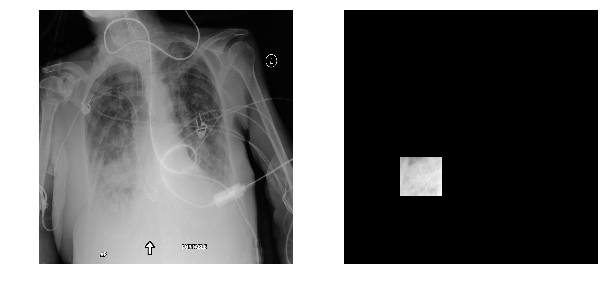

In [19]:
# Load and display random sample and their bounding boxes

class_ids = [0]
while class_ids[0] == 0:  # look for a mask
    image_id = random.choice(dataset_train.image_ids)
    image_fp = dataset_train.image_reference(image_id)
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)

print(image.shape)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.axis('off')

plt.subplot(1, 2, 2)
masked = np.zeros(image.shape[:2])
for i in range(mask.shape[2]):
    masked += image[:, :, 0] * mask[:, :, i]
plt.imshow(masked, cmap='gray')
plt.axis('off')

print(image_fp)
print(class_ids)

### Image Augmentation.
We will attempt to boost our performance by augmenting our training images. This will allow us to have more training samples (data is king) and improve our classification of slanted or poorly positioned patients. We will do the following transformations:
1. Geometric - Scaling image up and down, translating it along the two axis, rotating it 6 degrees clockwise and anti-clockwise, and finally shear it (ie. stretch)
2. Color - We will augment the contrast by changing the range of pixel intensities, and brightness by simply multiplying pixel values.
3. Edge - We will reduce edges by introducing a gaussian blur, allowing the model to focus on blobs of opacity, as well as sharpen some samples by intensifying boundary changes in pixel intensities in the image.

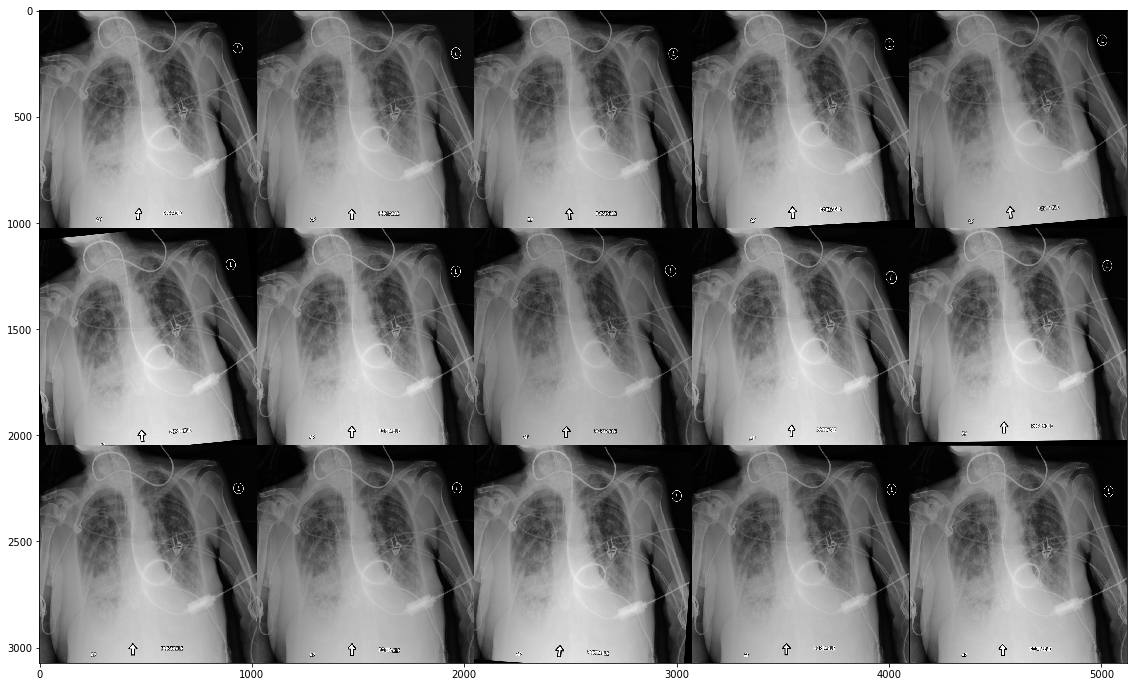

In [20]:
augmentation = iaa.Sequential([
    iaa.OneOf([ ## geometric transformations
        iaa.Affine(
            scale={"x": (0.98, 1.02), "y": (0.98, 1.02)},
            translate_percent={"x": (-0.02, 0.02), "y": (-0.04, 0.04)},
            rotate=(-6, 6),
            shear=(-1, 1),
        ),
        iaa.PiecewiseAffine(scale=(0.001, 0.025)),
    ]),
    iaa.OneOf([ ## intensity or contrast
        iaa.Multiply((0.9, 1.1)),
        iaa.ContrastNormalization((0.9, 1.1)),
    ]),
    iaa.OneOf([ ## blur or sharpen
        iaa.GaussianBlur(sigma=(0.0, 0.1)),
        iaa.Sharpen(alpha=(0.0, 0.1)),
    ]),
])

imggrid = augmentation.draw_grid(image[:, :, 0], cols=5, rows=3)
plt.figure(figsize=(30, 12))
_ = plt.imshow(imggrid[:, :, 0], cmap='gray')

### Now it's time to train the model.

- dataset_train and dataset_val are derived from DetectorDataset 
- DetectorDataset loads images from image filenames and  masks from the annotation data
- model is Mask-RCNN (pretrained with COCO weights)

In [21]:
model = modellib.MaskRCNN(mode='training', config=config, model_dir=ROOT_DIR)

# Exclude the last layers because they require a matching
# number of classes
model.load_weights(COCO_WEIGHTS_PATH, by_name=True, exclude=[
    "mrcnn_class_logits", "mrcnn_bbox_fc",
    "mrcnn_bbox", "mrcnn_mask"])

Instructions for updating:
Colocations handled automatically by placer.


In [22]:
LEARNING_RATE = 0.005

# Suppress warnings 
import warnings 
warnings.filterwarnings("ignore")

In [23]:
%%time
## train heads with higher lr to speedup the learning
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE*2,
            epochs=2,
            layers='heads',
            augmentation=None)  ## no need to augment yet
history = model.keras_model.history.history.copy()


Starting at epoch 0. LR=0.01

Checkpoint Path: /kaggle/working/pneumonia20190517T0724/mask_rcnn_pneumonia_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4  

In [24]:
%%time
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE,
            epochs=7,
            layers='all',
            augmentation=augmentation)
news = model.keras_model.history.history
for k in news: history[k] = history[k] + news[k]


Starting at epoch 2. LR=0.005

Checkpoint Path: /kaggle/working/pneumonia20190517T0724/mask_rcnn_pneumonia_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b  

In [25]:
%%time
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE/5,
            epochs=15,
            layers='all',
            augmentation=augmentation)
news = model.keras_model.history.history
for k in news: history[k] = history[k] + news[k]


Starting at epoch 7. LR=0.001

Checkpoint Path: /kaggle/working/pneumonia20190517T0724/mask_rcnn_pneumonia_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b  

In [26]:
epochs = range(1,len(next(iter(history.values())))+1)
pd.DataFrame(history, index=epochs)

,val_loss,val_rpn_class_loss,val_rpn_bbox_loss,val_mrcnn_class_loss,val_mrcnn_bbox_loss,val_mrcnn_mask_loss,loss,rpn_class_loss,rpn_bbox_loss,mrcnn_class_loss,mrcnn_bbox_loss,mrcnn_mask_loss
1,1.845374,0.057440,0.588711,0.323793,0.477764,0.397663,1.988923,0.060330,0.589005,0.375021,0.541533,0.423032
2,2.645107,0.089028,1.168578,0.321767,0.562097,0.503632,1.767447,0.059650,0.530920,0.318177,0.473916,0.384780
3,1.673249,0.054687,0.572844,0.240147,0.426223,0.379337,1.740182,0.054872,0.525133,0.302131,0.451022,0.407012
4,1.830946,0.058376,0.699061,0.246429,0.448200,0.378866,1.596627,0.048501,0.441420,0.288003,0.428770,0.389921
5,1.614017,0.045756,0.469735,0.269318,0.434872,0.394321,1.531209,0.043752,0.419750,0.272511,0.412318,0.382864
6,1.525956,0.042941,0.397974,0.289827,0.431749,0.363449,1.562098,0.040458,0.437660,0.264290,0.426728,0.392947
7,1.558481,0.044344,0.418575,0.262897,0.450150,0.382498,1.534072,0.041347,0.430362,0.266096,0.412054,0.384197
8,1.384774,0.032722,0.414368,0.200066,0.372669,0.364932,1.353538,0.031807,0.358649,0.213822,0.374561,0.374682
9,1.420466,0.030538,0.418840,0.196422,0.394746,0.379902,1.296784,0.026874,0.326543,0.206627,0.364346,0.372376
10,1.302143,0.032146,0.350952,0.183604,0.368090,0.367334,1.307816,0.029193,0.328102,0.222770,0.356959,0.370774


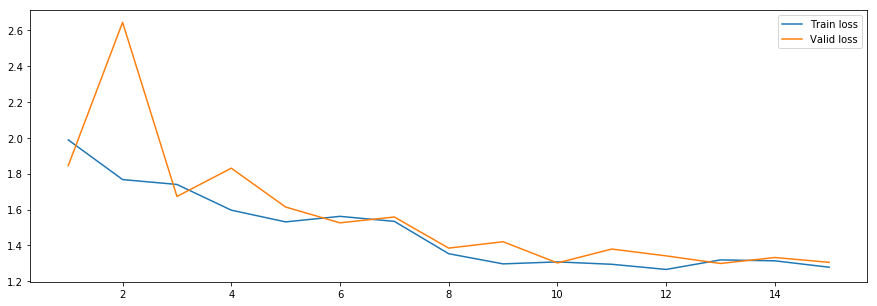

In [27]:
plt.figure(figsize=(15,5))
plt.subplot(111)
plt.plot(epochs, history["loss"], label="Train loss")
plt.plot(epochs, history["val_loss"], label="Valid loss")
plt.legend()
plt.show()

In [28]:
# select trained model 
dir_names = next(os.walk(model.model_dir))[1]
key = config.NAME.lower()
dir_names = filter(lambda f: f.startswith(key), dir_names)
dir_names = sorted(dir_names)

if not dir_names:
    import errno
    raise FileNotFoundError(
        errno.ENOENT,
        "Could not find model directory under {}".format(self.model_dir))
    
fps = []
# Pick last directory
for d in dir_names: 
    dir_name = os.path.join(model.model_dir, d)
    # Find the last checkpoint
    checkpoints = next(os.walk(dir_name))[2]
    checkpoints = filter(lambda f: f.startswith("mask_rcnn"), checkpoints)
    checkpoints = sorted(checkpoints)
    if not checkpoints:
        print('No weight files in {}'.format(dir_name))
    else:
        checkpoint = os.path.join(dir_name, checkpoints[-1])
        fps.append(checkpoint)

model_path = sorted(fps)[-1]
print('Found model {}'.format(model_path))

Found model /kaggle/working/pneumonia20190517T0724/mask_rcnn_pneumonia_0015.h5


In [29]:
class InferenceConfig(DetectorConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir=ROOT_DIR)

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Instructions for updating:
Use tf.cast instead.
Loading weights from  /kaggle/working/pneumonia20190517T0724/mask_rcnn_pneumonia_0015.h5
Re-starting from epoch 15


In [30]:
# set color for class
def get_colors_for_class_ids(class_ids):
    colors = []
    for class_id in class_ids:
        if class_id == 1:
            colors.append((.941, .204, .204))
    return colors

### How does the predicted box compared to the expected value? Let's use the validation dataset to check. 

Note that we trained only one epoch for **demonstration purposes ONLY**. You might be able to improve performance running more epochs. 

(256, 256, 3)

*** No instances to display *** 

(256, 256, 3)

*** No instances to display *** 

(256, 256, 3)

*** No instances to display *** 

(256, 256, 3)
(256, 256, 3)

*** No instances to display *** 

(256, 256, 3)

*** No instances to display *** 



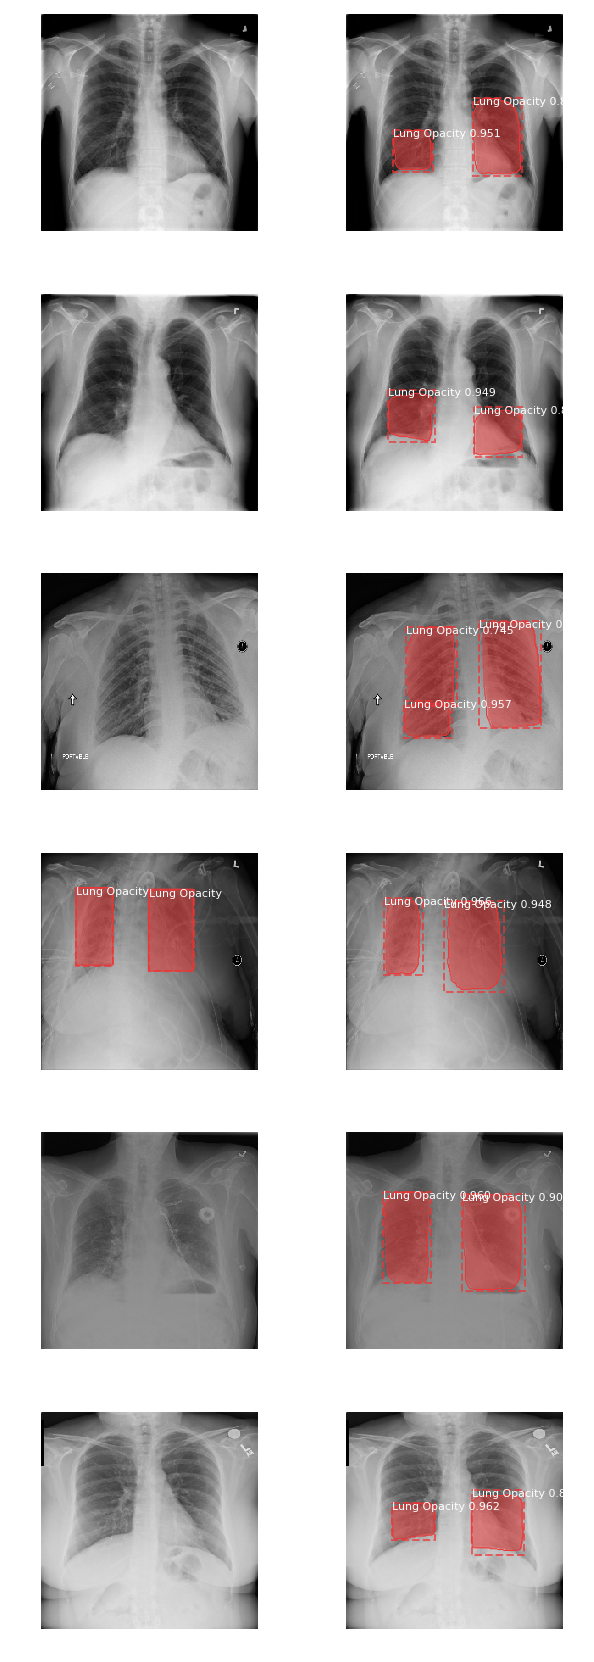

In [31]:
# Show few example of ground truth vs. predictions on the validation dataset 
dataset = dataset_val
fig = plt.figure(figsize=(10, 30))

for i in range(6):

    image_id = random.choice(dataset.image_ids)
    
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config, 
                               image_id, use_mini_mask=False)
    
    print(original_image.shape)
    plt.subplot(6, 2, 2*i + 1)
    visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                                dataset.class_names,
                                colors=get_colors_for_class_ids(gt_class_id), ax=fig.axes[-1])
    
    plt.subplot(6, 2, 2*i + 2)
    results = model.detect([original_image]) #, verbose=1)
    r = results[0]
    visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                                dataset.class_names, r['scores'], 
                                colors=get_colors_for_class_ids(r['class_ids']), ax=fig.axes[-1])

In [32]:
# Get filenames of test dataset DICOM images
test_image_fps = get_dicom_fps(test_dicom_dir)

### Final steps - Create the submission file

In [33]:
# Make predictions on test images, write out sample submission
def predict(image_fps, filepath='submission.csv', min_conf=0.95):
    # assume square image
    resize_factor = ORIG_SIZE / config.IMAGE_SHAPE[0]
    #resize_factor = ORIG_SIZE
    with open(filepath, 'w') as file:
        file.write("patientId,PredictionString\n")

        for image_id in tqdm(image_fps):
            ds = pydicom.read_file(image_id)
            image = ds.pixel_array
            # If grayscale. Convert to RGB for consistency.
            if len(image.shape) != 3 or image.shape[2] != 3:
                image = np.stack((image,) * 3, -1)
            image, window, scale, padding, crop = utils.resize_image(
                image,
                min_dim=config.IMAGE_MIN_DIM,
                min_scale=config.IMAGE_MIN_SCALE,
                max_dim=config.IMAGE_MAX_DIM,
                mode=config.IMAGE_RESIZE_MODE)

            patient_id = os.path.splitext(os.path.basename(image_id))[0]

            results = model.detect([image])
            r = results[0]

            out_str = ""
            out_str += patient_id
            out_str += ","
            assert( len(r['rois']) == len(r['class_ids']) == len(r['scores']) )
            if len(r['rois']) == 0:
                pass
            else:
                num_instances = len(r['rois'])

                for i in range(num_instances):
                    if r['scores'][i] > min_conf:
                        out_str += ' '
                        out_str += str(round(r['scores'][i], 2))
                        out_str += ' '

                        # x1, y1, width, height
                        x1 = r['rois'][i][1]
                        y1 = r['rois'][i][0]
                        width = r['rois'][i][3] - x1
                        height = r['rois'][i][2] - y1
                        bboxes_str = "{} {} {} {}".format(x1*resize_factor, y1*resize_factor, \
                                                           width*resize_factor, height*resize_factor)
                        out_str += bboxes_str

            file.write(out_str+"\n")

In [34]:
submission_fp = os.path.join(ROOT_DIR, 'submission.csv')
predict(test_image_fps, filepath=submission_fp)
print(submission_fp)

100%|██████████| 3000/3000 [10:04<00:00,  7.41it/s]

/kaggle/working/submission.csv


In [35]:
output = pd.read_csv(submission_fp, names=['patientId', 'PredictionString'])
output.head(60)

,patientId,PredictionString
0,patientId,PredictionString
1,0fcb8bee-5859-4cea-8320-7afdb6b8e293,0.95 240.0 192.0 284.0 256.0
2,13455fde-0e70-408a-a177-8acf2dfd1966,0.97 592.0 220.0 264.0 352.0 0.97 164.0 200.0...
3,1a3e7d64-adbc-4c49-abbe-3f871f3c557a,0.96 244.0 204.0 296.0 684.0
4,010f1670-a3f9-4186-b54f-720e3a78b9fd,0.96 224.0 480.0 228.0 260.0
5,26aff0c5-644d-4bde-9716-3b7605496da4,NaN
6,1e43a738-b9b6-48ec-96de-f527264904f2,0.98 180.0 416.0 308.0 516.0 0.96 604.0 268.0...
7,300ed19d-d398-4e56-b131-555f3a9a4017,0.98 208.0 488.0 204.0 196.0
8,2b301603-0de0-4c9c-89b4-81b91053e9ef,0.95 308.0 452.0 140.0 192.0
9,c10e8c73-8d1b-4abd-b6ad-7fbbe0a18346,0.97 256.0 228.0 220.0 364.0


008ca187-f164-4a2b-b14e-29d4e16e3a66
[129  66 166 107]
x 264 y 516 h 164 w 148
[137 182 173 223]
x 728 y 548 h 164 w 144
019a638a-305f-422d-aec7-f1081f510046
[133 145 207 204]
x 580 y 532 h 236 w 296
[143  59 181 105]
x 236 y 572 h 184 w 152
[ 79  51 134 101]
x 204 y 316 h 200 w 220
00dddf53-486f-4098-9a5e-b7d0b8ee2b8f
[ 63 160 163 220]
x 640 y 252 h 240 w 400
[ 37  33 148 123]
x 132 y 148 h 360 w 444
21b0c6dd-5278-43f6-ac94-4f5c443a2c45
[ 54  66 161 118]
x 264 y 216 h 208 w 428
[ 63 149 171 212]
x 596 y 252 h 252 w 432


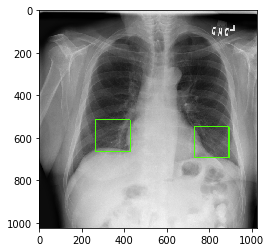

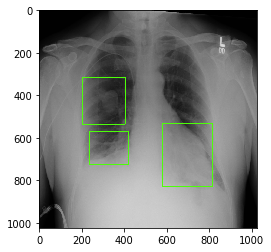

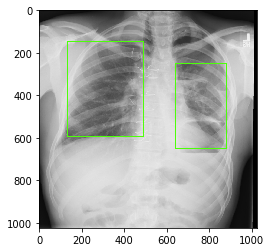

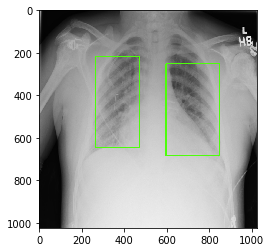

In [36]:
# show a few test image detection example
def visualize(): 
    image_id = random.choice(test_image_fps)
    ds = pydicom.read_file(image_id)
    
    # original image 
    image = ds.pixel_array
    
    # assume square image 
    resize_factor = ORIG_SIZE / config.IMAGE_SHAPE[0]
    
    # If grayscale. Convert to RGB for consistency.
    if len(image.shape) != 3 or image.shape[2] != 3:
        image = np.stack((image,) * 3, -1) 
    resized_image, window, scale, padding, crop = utils.resize_image(
        image,
        min_dim=config.IMAGE_MIN_DIM,
        min_scale=config.IMAGE_MIN_SCALE,
        max_dim=config.IMAGE_MAX_DIM,
        mode=config.IMAGE_RESIZE_MODE)

    patient_id = os.path.splitext(os.path.basename(image_id))[0]
    print(patient_id)

    results = model.detect([resized_image])
    r = results[0]
    for bbox in r['rois']: 
        print(bbox)
        x1 = int(bbox[1] * resize_factor)
        y1 = int(bbox[0] * resize_factor)
        x2 = int(bbox[3] * resize_factor)
        y2 = int(bbox[2]  * resize_factor)
        cv2.rectangle(image, (x1,y1), (x2,y2), (77, 255, 9), 3, 1)
        width = x2 - x1 
        height = y2 - y1 
        print("x {} y {} h {} w {}".format(x1, y1, width, height))
    plt.figure() 
    plt.imshow(image, cmap=plt.cm.gist_gray)

visualize()
visualize()
visualize()
visualize()